In [1]:
%load_ext autotime

In [2]:
# The name of the model (saved as {name}.h5 in trained_models folder)
model_to_evaluate = '5_1_shared_net_70'

# The device to evaluate model on
gpu = '/GPU:0'

# whether the model outputs prediction as one or two classes
num_classes = 1

time: 1.58 ms


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet169
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models
from keras.utils import plot_model, multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras_applications.densenet import *

from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress, HTML, HBox


from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


time: 2.74 s


In [4]:
import logging

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

time: 1.05 ms


In [5]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 3.01 s


In [6]:
import utils # importing from our utils functions

time: 4.76 s


In [7]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 16.1 s


In [8]:
x_train.shape

(36808, 256, 256)

time: 2.59 ms


In [9]:
size = x_train.shape[1]
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 6.93 ms


## Load model and prepare data

In [10]:
model_file = f'./trained_models/{model_to_evaluate}.h5'
log.info(f'Loading model from {model_file}...')
with tf.device(gpu):
    model = load_model(model_file, custom_objects={'loss': utils.weighted_binary_crossentropy(y_train.mean())})

INFO:__main__:Loading model from ./trained_models/5_1_shared_net_70.h5...


time: 2min 19s


In [11]:
log.info('Preparing dataset...')
x_test, y_test = utils.read_mura_pickle(sample='valid')
size = x_test.shape[1]
x_test = x_test.reshape(x_test.shape[0], size, size, 1)
x_test = utils.normalize_pixels(x_test)
true_label = y_test

log.info('Making predictions...')
y_test_hat = model.predict(x_test)
if num_classes == 1:
    pred_label = np.round(y_test_hat)
elif num_classes == 2:
    pred_label = np.argmax(y_test_hat, axis=1)
else:
    log.error('num_classes must be either 1 or 2!')

INFO:__main__:Preparing dataset...
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl
INFO:__main__:Making predictions...


time: 45.1 s


In [12]:
metrics = utils.MURAMetrics(true_label, pred_label)

time: 39.4 ms


In [13]:
y_df = pd.DataFrame({'true_label': true_label, 'predicted_prob': y_test_hat[:, 0], 'predicted_label': pred_label[:, 0]})

time: 2.8 ms


In [31]:
y_df.loc[:, 'residual'] = y_df.true_label - y_df.predicted_prob
y_df.loc[:, 'absolute_residual'] = y_df.residual.abs()
y_df.loc[:, 'certainty'] = y_df.predicted_prob.subtract(0.5).abs()

time: 9.27 ms


In [32]:
# Most correct / incorrect when target is 1
y_df_class1 = y_df[y_df.true_label.eq(1)].sort_values('absolute_residual')

time: 7.15 ms


# Most correct when target is 1

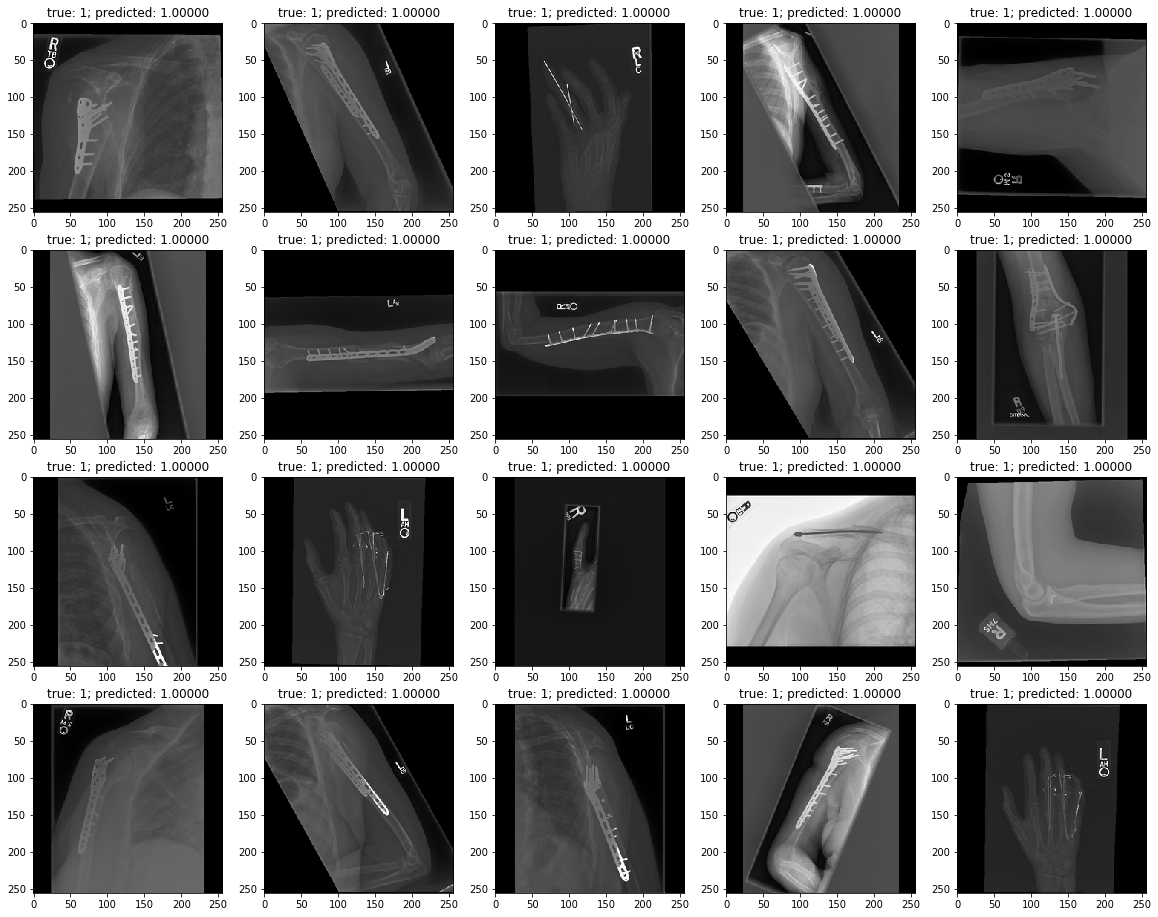

time: 1.57 s


In [33]:
f, a = plt.subplots(4, 5, figsize=(20, 16))

for j, i in enumerate(y_df_class1.head(20).index):
    a[j // 5, j % 5].imshow(x_test[i, :, :, 0], cmap='gray')
    a[j // 5, j % 5].set_title(f'true: {y_test[i]}; predicted: {y_df_class1.loc[i, "predicted_prob"]:.5f}')

plt.show()

# Most Incorrect when target is 1

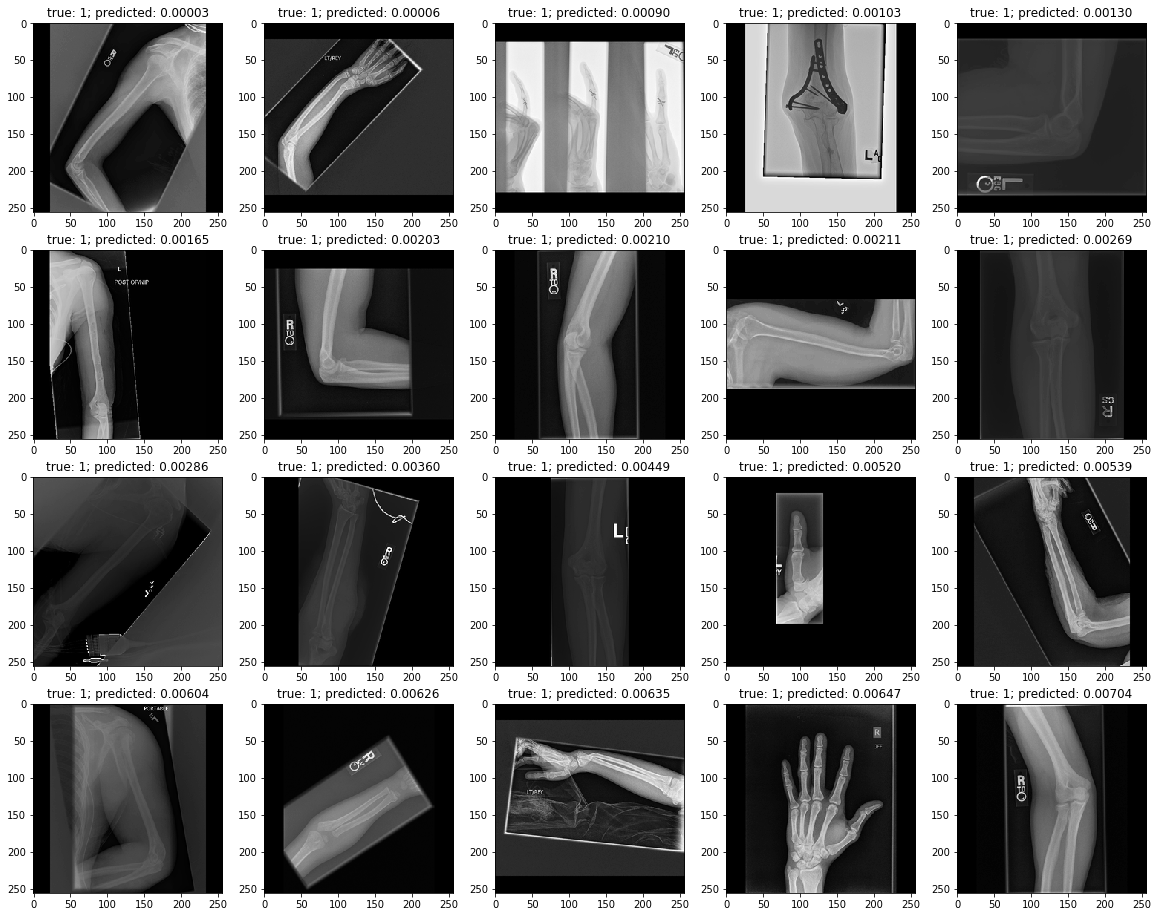

time: 1.54 s


In [34]:
f, a = plt.subplots(4, 5, figsize=(20, 16))

for j, i in enumerate(y_df_class1.tail(20).index[::-1]):
    a[j // 5, j % 5].imshow(x_test[i, :, :, 0], cmap='gray')
    a[j // 5, j % 5].set_title(f'true: {y_test[i]}; predicted: {y_df_class1.loc[i, "predicted_prob"]:.5f}')

plt.show()

# Most Uncertain when target is 1

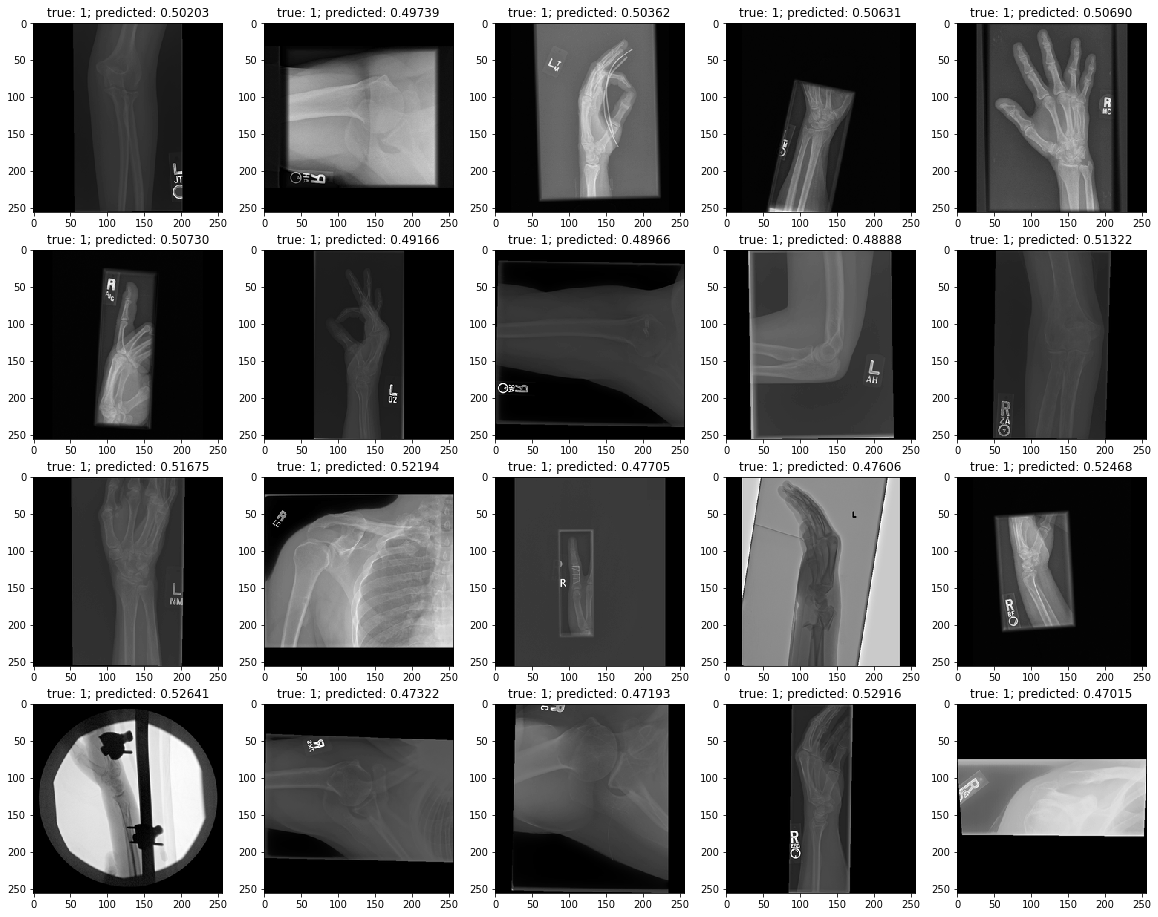

time: 1.57 s


In [35]:
f, a = plt.subplots(4, 5, figsize=(20, 16))

for j, i in enumerate(y_df_class1.sort_values('certainty').head(20).index):
    a[j // 5, j % 5].imshow(x_test[i, :, :, 0], cmap='gray')
    a[j // 5, j % 5].set_title(f'true: {y_test[i]}; predicted: {y_df_class1.loc[i, "predicted_prob"]:.5f}')

plt.show()

In [36]:
# Most correct / incorrect when target is 0
y_df_class0 = y_df[y_df.true_label.eq(0)].sort_values('absolute_residual')

time: 6.31 ms


# Most Correct When Target is 0

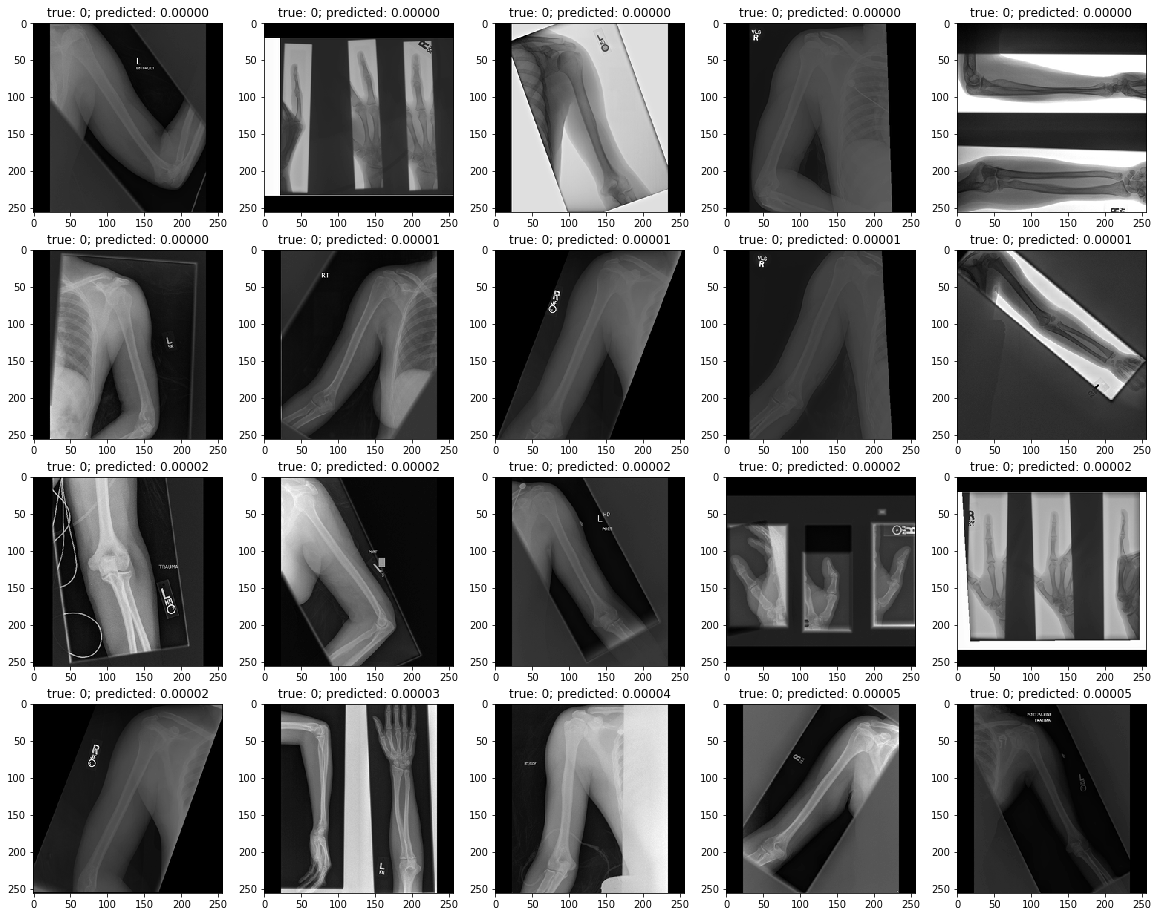

time: 1.62 s


In [37]:
f, a = plt.subplots(4, 5, figsize=(20, 16))

for j, i in enumerate(y_df_class0.head(20).index):
    a[j // 5, j % 5].imshow(x_test[i, :, :, 0], cmap='gray')
    a[j // 5, j % 5].set_title(f'true: {y_test[i]}; predicted: {y_df_class0.loc[i, "predicted_prob"]:.5f}')

plt.show()

# Most Incorrect When Target is 0

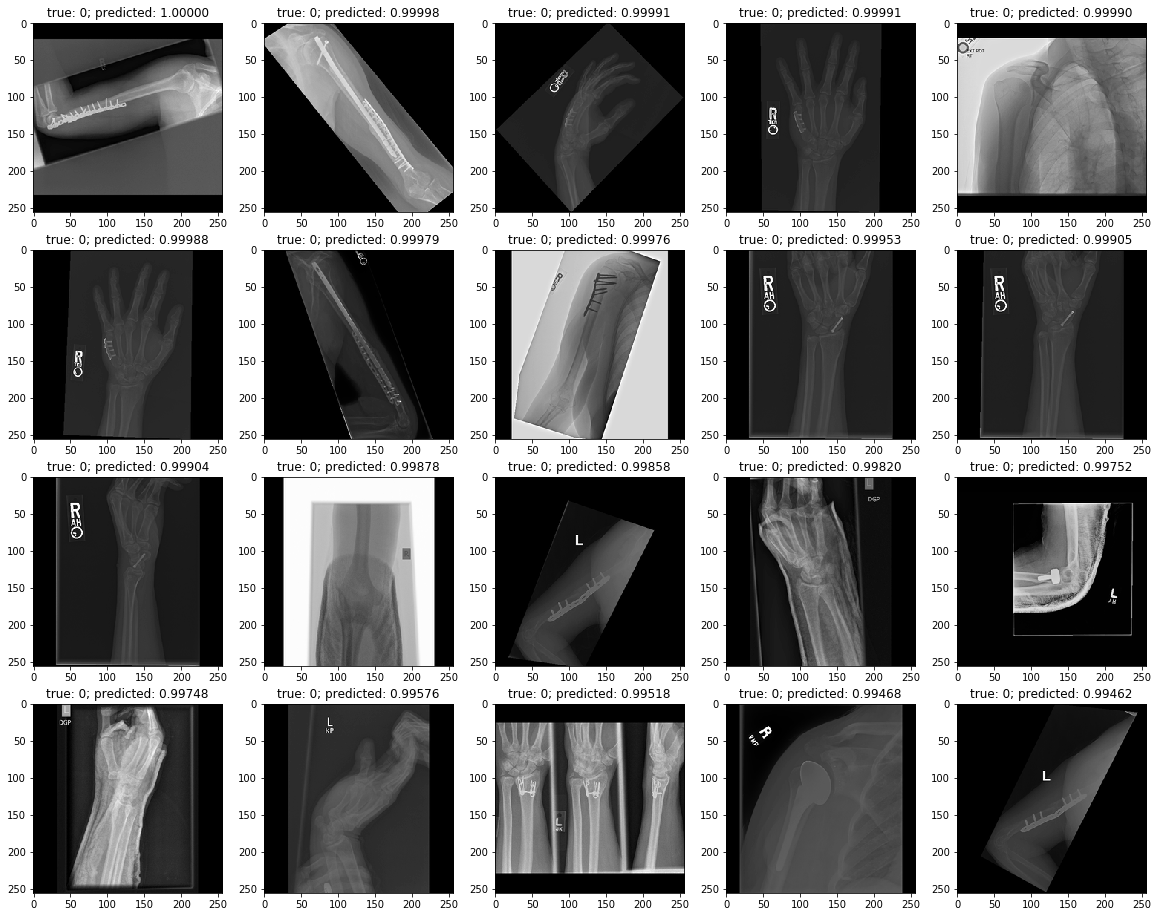

time: 1.56 s


In [39]:
f, a = plt.subplots(4, 5, figsize=(20, 16))

for j, i in enumerate(y_df_class0.tail(20).index[::-1]):
    a[j // 5, j % 5].imshow(x_test[i, :, :, 0], cmap='gray')
    a[j // 5, j % 5].set_title(f'true: {y_test[i]}; predicted: {y_df_class0.loc[i, "predicted_prob"]:.5f}')

plt.show()

# Most Uncertain when target is 0

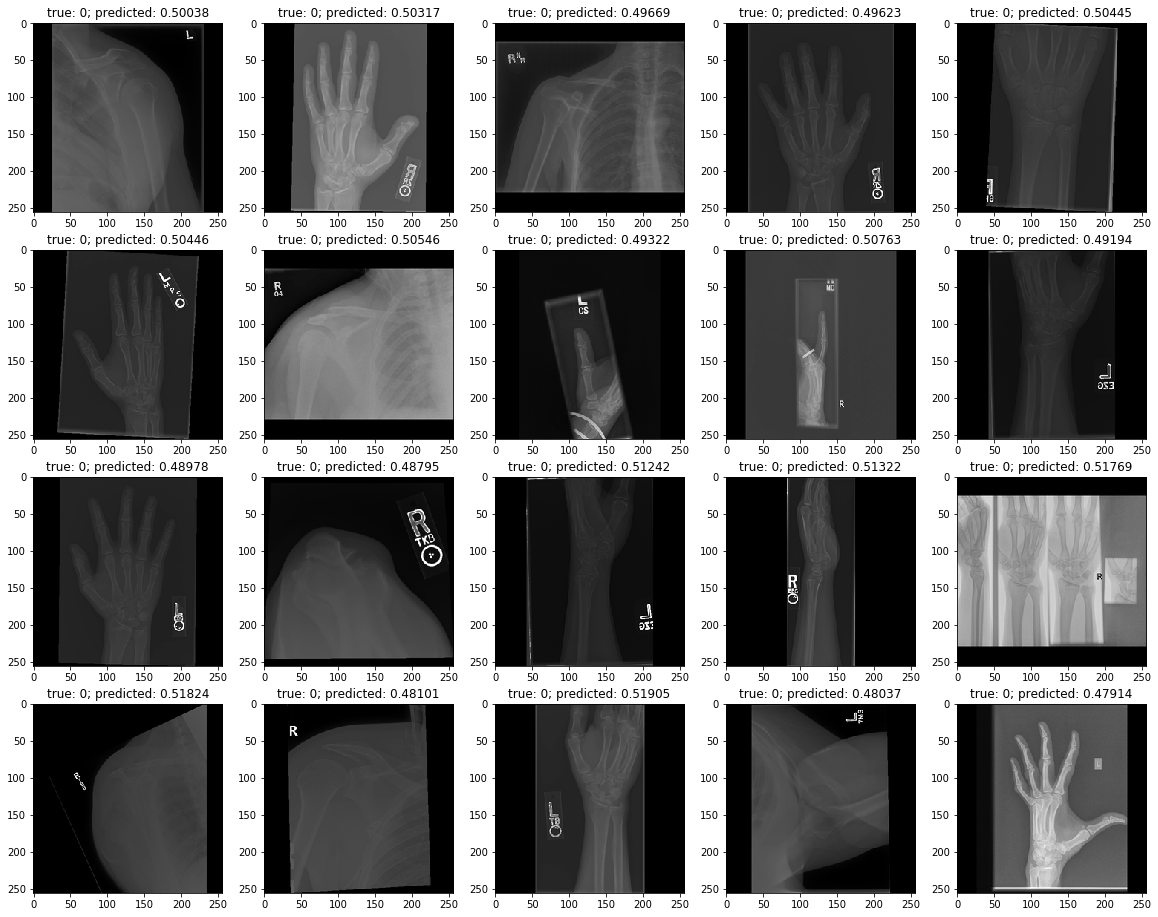

time: 1.58 s


In [40]:
f, a = plt.subplots(4, 5, figsize=(20, 16))

for j, i in enumerate(y_df_class0.sort_values('certainty').head(20).index):
    a[j // 5, j % 5].imshow(x_test[i, :, :, 0], cmap='gray')
    a[j // 5, j % 5].set_title(f'true: {y_test[i]}; predicted: {y_df_class0.loc[i, "predicted_prob"]:.5f}')

plt.show()

In [21]:
y_df_class0.head(20).index[2]

1661

time: 9.58 ms


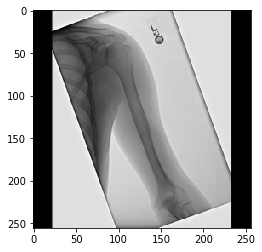

time: 110 ms


In [22]:
plt.imshow(x_test[1661, :, :, 0], cmap='gray')

(array([11606.,   876.,  3181.,  5179.,  4314.,  4658.,  3521.,  6865.,
        23711.,  1625.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

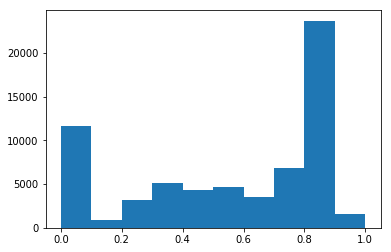

time: 106 ms


In [23]:
plt.hist(np.reshape(x_test[1661, :, :, 0], (256*256, 1)))

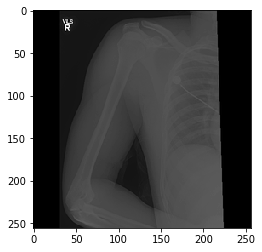

time: 145 ms


In [24]:
plt.imshow(x_test[1664, :, :, 0], cmap='gray')

(array([2.4622e+04, 3.3100e+03, 2.0294e+04, 1.7232e+04, 1.2000e+01,
        1.3000e+01, 1.6000e+01, 1.2000e+01, 5.0000e+00, 2.0000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

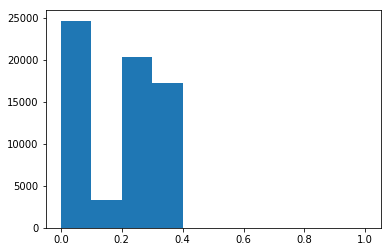

time: 128 ms


In [25]:
plt.hist(np.reshape(x_test[1664, :, :, 0], (256*256, 1)))

In [26]:
y_df_class0.tail(20).index[::-1][16]

3086

time: 2.25 ms


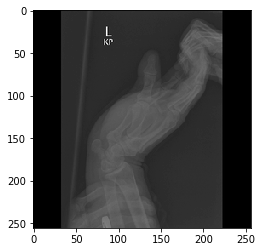

time: 108 ms


In [27]:
plt.imshow(x_test[3086, :, :, 0], cmap='gray')

In [28]:
metrics.valid_groups.iloc[3086]

0               MURA-v1.1/valid/XR_FINGER/patient11739/study1_...
body_part                                                  finger
patient_id                                                  11739
study_id                                                        1
target_label                                                    0
image_id                                                        1
true_label                                                      0
pred_label                                                      1
Name: 3086, dtype: object

time: 4.3 ms
